In [16]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from collections import defaultdict
from IPython.display import clear_output

import sys
sys.path.append("ComputeCanada/frequency_tagging")
from utils import (
    get_roi_colour_codes,
    change_font,
    HCP_ATLAS as hcp_label,
    dfm_generate_single_subject_maps,
    NORMAL_3T_SUB_IDS,
    NORMAL_7T_SUB_IDS,
    VARY_SUB_IDS,
    VARY_020_ENTRAIN_CONDITIONS,
    VARY_021_ENTRAIN_CONDITIONS,
    PICKLE_DIR,
    MAIN
)
change_font()

tmpdir = Path("/tmp")

#### Get HCP info
- `hcp_mappings`: dict of ROI: dscalars

In [3]:
"""Get HCP labels
"""
_HCP_INFO = !wb_command -file-information {hcp_label}
HCP_LABELS = []
HCP_COUNTER = 0
for i in _HCP_INFO:
    if len(i) == 60 and any(["L_" in i, "R_" in i]):
        hcp_colors = tuple([float(f"0.{k}") for k in [j.split(' ') [0] for j in i.split('0.')][-3:]] + [1])
        if ' R_' in i:
            roi = i.split("_ROI")[0].split(' R_')[1]
            HCP_LABELS.append(f"R_{roi}_ROI")
        if ' L_' in i:
            roi = i.split("_ROI")[0].split(' L_')[1]
            HCP_LABELS.append(f"L_{roi}_ROI")
        HCP_COUNTER += 1

"""Get HCP label coordinates
"""
hcp_mapping = {}
for roi_label in HCP_LABELS:
    out_dscalar = tmpdir / f"{roi_label}.dscalar.nii"
    if out_dscalar.exists():
        hcp_mapping[roi_label] = out_dscalar
        continue
    !wb_command -cifti-label-to-roi {hcp_label} {out_dscalar} -name {roi_label}
    assert out_dscalar.exists(), f"{out_dscalar.stem} does not exist."
    hcp_mapping[roi_label] = out_dscalar
hcp_rois = list(set([k.split('_')[1] for k in hcp_mapping.keys()]))

#### Generate dual frequency tagging maps:
- Runtime: `corr_types = "uncp"`: ~45 minutes
- Runtime: `corr_types = "fdrp"`: TBD

In [ ]:
"""Set up for visualizing dual frequency tagging across each subject using fractional overlap
"""
ROI_FO = .8
corr_type = "fdrp"
FORCE_RUN = False

"""Save png
"""
df_map_pkl = PICKLE_DIR / f"df_map_corr-{corr_type}.pkl"
if df_map_pkl.exists() and not FORCE_RUN:
    df = pd.read_pickle(df_map_pkl)
else:
    # 3T control/entrain
    label = "3TNormal"
    df_data = None
    for _roi_task_id in ["entrain","control"]:
        experiment_id = "1_frequency_tagging" 
        mri_id = "3T"
        n_subjects = len(NORMAL_3T_SUB_IDS)
        roi_task_ids = [_roi_task_id] * n_subjects
        roi_f_1s = [.125] * n_subjects
        roi_f_2s = [.2] * n_subjects
        df_data = dfm_generate_single_subject_maps(
            hcp_mapping,
            label, experiment_id, mri_id, NORMAL_3T_SUB_IDS, 
            roi_task_ids, roi_f_1s, roi_f_2s, ROI_FO,
            df_data=df_data,
            corr_type=corr_type,
            ROI_FO=ROI_FO,
        )
        clear_output()
    # 7T AttendAway
    label = "7TNormal"
    experiment_id = "1_attention" 
    mri_id = "7T"
    n_subjects = len(NORMAL_7T_SUB_IDS)
    roi_task_ids = ["AttendAway"] * n_subjects
    roi_f_1s = [.125] * n_subjects
    roi_f_2s = [.2] * n_subjects
    df_data = dfm_generate_single_subject_maps(
        hcp_mapping,
        label, experiment_id, mri_id, NORMAL_7T_SUB_IDS, 
        roi_task_ids, roi_f_1s, roi_f_2s, ROI_FO,
        df_data=df_data,
        corr_type=corr_type,
        ROI_FO=ROI_FO
    )
    clear_output()
    # 3T/7T vary
    experiment_id = "1_frequency_tagging"
    for label, mri_id in zip(["3TVary","7TVary"], ["3T","7T"]):
        sub_ids = [VARY_SUB_IDS[0]] * 3 + [VARY_SUB_IDS[1]] * 3
        roi_task_ids = [i[0] for i in VARY_020_ENTRAIN_CONDITIONS] + [i[0] for i in VARY_021_ENTRAIN_CONDITIONS]
        roi_f_1s = [i[1] for i in VARY_020_ENTRAIN_CONDITIONS] + [i[1] for i in VARY_021_ENTRAIN_CONDITIONS]
        roi_f_2s = [i[2] for i in VARY_020_ENTRAIN_CONDITIONS] + [i[2] for i in VARY_021_ENTRAIN_CONDITIONS]
        df_data = dfm_generate_single_subject_maps(
            hcp_mapping,
            label, experiment_id, mri_id, sub_ids,
            roi_task_ids, roi_f_1s, roi_f_2s, ROI_FO,
            df_data=df_data,
            corr_type=corr_type,
            ROI_FO=ROI_FO
        )
        clear_output()
    df = pd.DataFrame(df_data)
    df.to_pickle(df_map_pkl)

#### Generate f1, f2 locked maps across MRI strength and varying entrainment experiments
- sub_ids = 020, 021

In [ ]:
from utils import (
    load_mean_dtseries,
    WORKING_DIR,
    crop_and_save,
)

from wbplot import dscalar

DFM_VARY_LOCKED_MAPS = WORKING_DIR / "figures" / "dual_frequency_mapping" / "locked_vary_maps"
if not DFM_VARY_LOCKED_MAPS.exists():
    DFM_VARY_LOCKED_MAPS.mkdir(parents=True, exist_ok=True)

VERTEX_TO = 59412
PALETTE_PARAMS = {
    "disp-zero": False,
    "disp-neg": False,
    "disp-pos": True,
    "pos-user": (0, 1.),
    "neg-user": (-1,0),
    "interpolate": True,
}
# Cropped settings
LEFT=590;TOP=80;RIGHT=1140;BOTTOM=460


In [ ]:
expected_n_runs = 6

for sub_id in ["020", "021"]:

    if sub_id == "020":
        entrain_conditions = [i[0] for i in VARY_020_ENTRAIN_CONDITIONS]
    elif sub_id == "021":
        entrain_conditions = [i[0] for i in VARY_021_ENTRAIN_CONDITIONS]

    entrain_f1 = []
    entrain_f2 = []
    entrain1_activations = !ls /scratch/fastfmri/*merged*basic*roi-entrain*uncp*/sub-{sub_id}/bootstrap/*task-{entrain_conditions[0]}*data-train*activations*
    entrain_f1.append(entrain1_activations[0])
    entrain_f2.append(entrain1_activations[1])
    entrain_f1.append(entrain1_activations[2])
    entrain_f2.append(entrain1_activations[3])
    entrain2_activations = !ls /scratch/fastfmri/*merged*basic*roi-entrain*uncp*/sub-{sub_id}/bootstrap/*task-{entrain_conditions[1]}*data-train*activations*
    entrain_f1.append(entrain2_activations[0])
    entrain_f2.append(entrain2_activations[1])
    entrain_f1.append(entrain2_activations[2])
    entrain_f2.append(entrain2_activations[3])
    entrain3_activations = !ls /scratch/fastfmri/*merged*basic*roi-entrain*uncp*/sub-{sub_id}/bootstrap/*task-{entrain_conditions[2]}*data-train*activations*
    entrain_f1.append(entrain3_activations[0])
    entrain_f2.append(entrain3_activations[1])
    entrain_f1.append(entrain3_activations[2])
    entrain_f2.append(entrain3_activations[3])

    assert len(entrain_f1) == expected_n_runs, f"{len(entrain_f1)} vs {expected_n_runs}"
    assert len(entrain_f2) == expected_n_runs

    for entrain_descriptor, entrain_f in zip(["f1","f2"],[entrain_f1, entrain_f2]):
        png_out = DFM_VARY_LOCKED_MAPS / f"sub-{sub_id}_{entrain_descriptor}.png"
        for ix, activation in enumerate(entrain_f):
            _data = (load_mean_dtseries(activation)[:VERTEX_TO] > .8).astype(float)
            if ix == 0:
                data = _data
            else:
                data += _data
        data /= 6
        dscalar(
            png_out, data, 
            orientation="portrait", 
            hemisphere='right',
            palette="magma", 
            palette_params=PALETTE_PARAMS,
            transparent=False,
            flatmap=True,
            flatmap_style='plain',
        )
        crop_and_save(png_out, str(png_out).replace("png", "cropped.png"), LEFT, TOP, RIGHT, BOTTOM)
        clear_output()

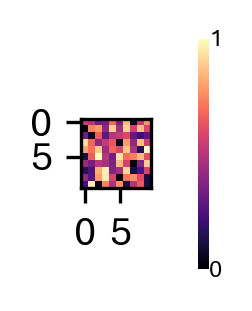

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create some example data
data = np.random.rand(10, 10)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(1,1), dpi=300)

# Plot data on the axis with the 'magma' colormap
cax = ax.imshow(data, cmap='magma')

# Add a colorbar to the figure
cbar = fig.colorbar(cax, ax=ax, fraction=.5, pad=.2)
cbar.set_ticks([0,1])
cbar.set_ticklabels([0,1], fontsize=6)
for spine in cbar.ax.spines.values():
    spine.set_visible(False)

cbar.ax.tick_params("both",pad=0, length=0,)
fig.savefig(MAIN / f"Fig1_magma_cbar.png", dpi=300)
#plt.close()


# Below is not supported.

In [ ]:
"""Set up for visualizing dual frequency tagging across each subject using fractional overlap
"""
PALETTE = "power_surf"
f1_c = -.1 # red -.1
f2_c = .82 # blue .82
f1f2_c = .14 # white .88 yellow .1
mask_c = .41 # .9 [green], .1 [goldish], .4 [black]

cohort_roi_info_across_experiments = {}
ROI_FOS = [.8,1.]
corr_types = ["uncp"]

df_dict = {}
for corr_type in corr_types:
    """Save png
    """
    # 3T control under entrain condition (set this to get power measurements with entrain ROIs)
    label = "3TNormal"
    df_data = None
    for _roi_task_id in ["entrain"]:
        for ROI_FO in ROI_FOS:
            experiment_id = "1_frequency_tagging" 
            mri_id = "3T"
            sub_ids = ["000", "002", "003", "004", "005", "006", "007", "008", "009"] 
            roi_task_ids = [_roi_task_id] * len(sub_ids)
            roi_f_1s = [.125] * len(sub_ids)
            roi_f_2s = [.2] * len(sub_ids)
            df_data = generate_single_subject_maps(
                label, experiment_id, mri_id, sub_ids, 
                roi_task_ids, roi_f_1s, roi_f_2s, ROI_FO,
                df_data=df_data,
                corr_type=corr_type,
                ROI_FO=ROI_FO, SUB_THRESHOLD=.5,
                FORCE_TASK_ID="control"
            )
    # 3T normal
    label = "3TNormal"
    for _roi_task_id in ["entrain", "control"]:
        for ROI_FO in ROI_FOS:
            experiment_id = "1_frequency_tagging" 
            mri_id = "3T"
            sub_ids = ["000", "002", "003", "004", "005", "006", "007", "008", "009"] 
            roi_task_ids = [_roi_task_id] * len(sub_ids)
            roi_f_1s = [.125] * len(sub_ids)
            roi_f_2s = [.2] * len(sub_ids)
            df_data = generate_single_subject_maps(
                label, experiment_id, mri_id, sub_ids, 
                roi_task_ids, roi_f_1s, roi_f_2s, ROI_FO,
                df_data=df_data,
                corr_type=corr_type,
                ROI_FO=ROI_FO, SUB_THRESHOLD=.5
            )
    # 7T normal
    label = "7TNormal"
    for ROI_FO in ROI_FOS:
        experiment_id = "1_attention" 
        mri_id = "7T"
        sub_ids = ["Pilot001", "Pilot009", "Pilot010", "Pilot011"]
        roi_task_ids = ["AttendAway"] * len(sub_ids)
        roi_f_1s = [.125] * len(sub_ids)
        roi_f_2s = [.2] * len(sub_ids)
        df_data = generate_single_subject_maps(
            label, experiment_id, mri_id, sub_ids, 
            roi_task_ids, roi_f_1s, roi_f_2s, ROI_FO,
            df_data=df_data,
            corr_type=corr_type,
            ROI_FO=ROI_FO, SUB_THRESHOLD=.5
        )
    # 3T vary
    label = "3TVary"
    for ROI_FO in ROI_FOS:
        experiment_id = "1_frequency_tagging"
        mri_id = "3T"
        sub_ids = ["020"] * 3 + ["021"] * 3
        roi_task_ids = [f"entrain{i}" for i in ["A", "B", "C", "D", "E", "F"]]
        roi_f_1s = [.125] * 3 + [.125, .15, .175]
        roi_f_2s = [.2, .175, .15] + [.2] * 3
        df_data = generate_single_subject_maps(
            label, experiment_id, mri_id, sub_ids, 
            roi_task_ids, roi_f_1s, roi_f_2s, ROI_FO,
            df_data=df_data,
            corr_type=corr_type,
            ROI_FO=ROI_FO, SUB_THRESHOLD=.5
        )
    # 7T vary
    label = "7TVary"
    for ROI_FO in ROI_FOS:
        experiment_id = "1_frequency_tagging"
        mri_id = "7T"
        sub_ids = ["020"] * 3 + ["021"] * 3
        roi_task_ids = [f"entrain{i}" for i in ["A", "B", "C", "D", "E", "F"]]
        roi_f_1s = [.125] * 3 + [.125, .15, .175]
        roi_f_2s = [.2, .175, .15] + [.2] * 3
        df_data = generate_single_subject_maps(
            label, experiment_id, mri_id, sub_ids, 
            roi_task_ids, roi_f_1s, roi_f_2s, ROI_FO,
            df_data=df_data,
            corr_type=corr_type,
            ROI_FO=ROI_FO, SUB_THRESHOLD=.5
        )

    df_dict[corr_type] = pd.DataFrame(df_data)
    del df_data

from IPython.display import clear_output
clear_output()


In [ ]:
def count_vertices(subset_df):
    total_vertices = 0
    for i in subset_df.vertex_coordinates:
        total_vertices += i[0].shape[0]

    return total_vertices

In [ ]:
df = df_dict["uncp"]
frequency_of_rois = ["f1","f2","f1Uf2"]
frequency_metrics = ["f1_BOLD_power","f2_BOLD_power","f1_BOLD_power"]
df = df[(df.roi_fo)==.8]
experiment_ids = df.experiment_id.unique()
_dict = defaultdict(list)
for experiment_id in experiment_ids:
    _df = df[(df.experiment_id==experiment_id)]
    roi_task_ids = _df.roi_task_id.unique()
    for roi_task_id in roi_task_ids:
        for frequency_of_roi,f_metric in zip(frequency_of_rois,frequency_metrics):
            _df = df[(df.experiment_id==experiment_id) & (df.roi_task_id==roi_task_id) & (df.frequency_of_roi==frequency_of_roi)]
            sub_ids = _df.sub_id.unique()
            for sub_id in sub_ids:
                _df = df[(df.experiment_id==experiment_id) & (df.roi_task_id==roi_task_id) & (df.task_id==roi_task_id) & (df.frequency_of_roi==frequency_of_roi) & (df.sub_id==sub_id)]
                n_vertex = count_vertices(_df)
                
                print(sub_id, frequency_of_roi)
                _dict["experiment_id"].append(experiment_id)
                _dict["roi_task_id"].append(roi_task_id)
                _dict["frequency_of_roi"].append(frequency_of_roi)
                _dict["sub_id"].append(sub_id)
                _dict["vertex_count"].append(n_vertex)

voxel_df = pd.DataFrame(_dict)
voxel_df

In [ ]:
roi_c_dict = get_roi_colour_codes()
roi_c_dict["f1Uf2"] = roi_c_dict["f1f2"]
FONTSIZE=6
def round_up_to_nearest_hundred(num):
    import math
    return math.ceil(num / 100) * 100

Note: All counts include f1&f2 intersected ROIs. i.e., f1 vertex count includes f1&f2 vertices

In [ ]:
mosaic = [frequency_of_rois]
fig, ax_dict = plt.subplot_mosaic(mosaic,figsize=(1.7,1.2),dpi=300,layout="constrained")
for frequency_of_roi in frequency_of_rois:
    entrain = voxel_df[(voxel_df.experiment_id=="3TNormal") & (voxel_df.roi_task_id=="entrain") & (voxel_df.frequency_of_roi==frequency_of_roi)]
    sub_ids = entrain.sub_id.unique()
    entrain_data = []
    control_data = []
    for sub_id in sub_ids:
        entrain = voxel_df[(voxel_df.experiment_id=="3TNormal") & (voxel_df.roi_task_id=="entrain") & (voxel_df.frequency_of_roi==frequency_of_roi) & (voxel_df.sub_id==sub_id)]
        control = voxel_df[(voxel_df.experiment_id=="3TNormal") & (voxel_df.roi_task_id=="control") & (voxel_df.frequency_of_roi==frequency_of_roi) & (voxel_df.sub_id==sub_id)]
        if control.shape[0] == 0:
            control_data.append(0)
        else:
            control_data.append(control.vertex_count.values[0])
        entrain_data.append(entrain.vertex_count.values[0])
        
        ax = ax_dict[frequency_of_roi]
        ax.scatter(np.zeros_like(entrain_data)+1,entrain_data,c=roi_c_dict[frequency_of_roi],s=20,zorder=12,edgecolors='k',linewidths=.4)
        ax.scatter(np.zeros_like(control_data),control_data,c='grey',s=20,zorder=12,edgecolors='k',linewidths=.4)
        for _control_data, _entrain_data in zip(control_data,entrain_data):
            ax.plot([0,1],[_control_data,_entrain_data], lw=.4,c='k',linestyle='dotted',zorder=10)
        ax.set_xlim(-.4,1.4)
        ax.set_xticks([0,1])
        ax.set_xticklabels(["Control","Entrain"], fontsize=FONTSIZE,rotation=90)
        ymax = round_up_to_nearest_hundred(np.max(entrain_data))
        ax.set_ylim(-ymax*.2,ymax*1.2)
        ax.set_yticks([0,ymax/2,ymax])
        ax.set_yticklabels([0,int(ymax/2),ymax],fontsize=FONTSIZE)
        ax.tick_params("both",pad=.2,width=.4)

        for _spine in ["right","bottom","top"]:
            ax.spines[_spine].set_visible(False)
        ax.spines.left.set_linewidth(.4)
        ax.spines.left.set_bounds(0,ymax)
"""
# 7T
for frequency_of_roi in frequency_of_rois:
    entrain = voxel_df[(voxel_df.experiment_id=="7TNormal") & (voxel_df.roi_task_id=="AttendAway") & (voxel_df.frequency_of_roi==frequency_of_roi)]
    sub_ids = entrain.sub_id.unique()
    entrain_data = []
    for sub_id in sub_ids:
        entrain = voxel_df[(voxel_df.experiment_id=="7TNormal") & (voxel_df.roi_task_id=="AttendAway") & (voxel_df.frequency_of_roi==frequency_of_roi) & (voxel_df.sub_id==sub_id)]
        entrain_data.append(entrain.vertex_count.values[0])
        
    ax = ax_dict[frequency_of_roi]
    ax.scatter(np.zeros_like(entrain_data)+2,entrain_data,c=roi_c_dict[frequency_of_roi],s=20,zorder=12,edgecolors='k',linewidths=.4)
"""

ax_dict["f1"].set_ylabel("Voxel count", fontsize=FONTSIZE)


fig.savefig("I.png",dpi=600)

In [ ]:
mosaic = [frequency_of_rois]
fig, ax_dict = plt.subplot_mosaic(mosaic,figsize=(1.7,1.2),dpi=300,layout="constrained")
for mri_id in ["3T","7T"]:
    marker_style = 'o'
    if mri_id=="7T":
        marker_style="^"
    for frequency_of_roi in frequency_of_rois:
        entrain1 = voxel_df[(voxel_df.experiment_id==f"{mri_id}Vary") & (voxel_df.roi_task_id=="entrainA") & (voxel_df.frequency_of_roi==frequency_of_roi)]
        roi_task_ids = entrain1.roi_task_id.unique()
        entrain1_data = []
        entrain2_data = []
        entrain3_data = []
        entrain1 = voxel_df[(voxel_df.experiment_id==f"{mri_id}Vary") & (voxel_df.roi_task_id=="entrainA") & (voxel_df.frequency_of_roi==frequency_of_roi)]
        entrain2 = voxel_df[(voxel_df.experiment_id==f"{mri_id}Vary") & (voxel_df.roi_task_id=="entrainB") & (voxel_df.frequency_of_roi==frequency_of_roi)]
        entrain3 = voxel_df[(voxel_df.experiment_id==f"{mri_id}Vary") & (voxel_df.roi_task_id=="entrainC") & (voxel_df.frequency_of_roi==frequency_of_roi)]
        entrain1_data.append(entrain1.vertex_count.values[0])
        entrain2_data.append(entrain2.vertex_count.values[0])
        entrain3_data.append(entrain3.vertex_count.values[0])
        
        ax = ax_dict[frequency_of_roi]
        ax.scatter(np.zeros_like(entrain1_data)+0,entrain1_data,c=roi_c_dict[frequency_of_roi],s=20,zorder=12,edgecolors='k',linewidths=.4,marker=marker_style)
        ax.scatter(np.zeros_like(entrain2_data)+1,entrain2_data,c=roi_c_dict[frequency_of_roi],s=20,zorder=12,edgecolors='k',linewidths=.4,marker=marker_style)
        ax.scatter(np.zeros_like(entrain3_data)+2,entrain3_data,c=roi_c_dict[frequency_of_roi],s=20,zorder=12,edgecolors='k',linewidths=.4,marker=marker_style)
        #for _control_data, _entrain_data in zip():
            #ax.plot([0,1],[_control_data,_entrain_data], lw=.4,c='k',linestyle='dotted',zorder=10)
        ax.set_xlim(-.4,2.4)
        ax.set_xticks([0,1,2])
        ax.set_xticklabels(["1","2","3"], fontsize=FONTSIZE,rotation=90)
        #ymax = round_up_to_nearest_hundred(np.max(entrain1_data))
        #ax.set_ylim(-ymax*.2,ymax*1.2)
        #ax.set_yticks([0,ymax/2,ymax])
        #ax.set_yticklabels([0,int(ymax/2),ymax],fontsize=FONTSIZE)
        ax.tick_params("both",pad=.2,width=.4,labelsize=FONTSIZE)

        for _spine in ["right","bottom","top"]:
            ax.spines[_spine].set_visible(False)
        ax.spines.left.set_linewidth(.4)
        #ax.spines.left.set_bounds(0,ymax)

ax_dict["f1"].set_ylabel("Voxel count", fontsize=FONTSIZE)


fig.savefig("J.png",dpi=600)

In [ ]:

mosaic = [frequency_of_rois]
fig, ax_dict = plt.subplot_mosaic(mosaic,figsize=(1.7,1.2),dpi=300,layout="constrained")
for mri_id in ["3T","7T"]:
    marker_style = 'o'
    if mri_id=="7T":
        marker_style="^"
    for frequency_of_roi in frequency_of_rois:
        entrain1 = voxel_df[(voxel_df.experiment_id==f"{mri_id}Vary") & (voxel_df.roi_task_id=="entrainD") & (voxel_df.frequency_of_roi==frequency_of_roi)]
        roi_task_ids = entrain1.roi_task_id.unique()
        entrain1_data = []
        entrain2_data = []
        entrain3_data = []
        entrain1 = voxel_df[(voxel_df.experiment_id==f"{mri_id}Vary") & (voxel_df.roi_task_id=="entrainD") & (voxel_df.frequency_of_roi==frequency_of_roi)]
        entrain2 = voxel_df[(voxel_df.experiment_id==f"{mri_id}Vary") & (voxel_df.roi_task_id=="entrainE") & (voxel_df.frequency_of_roi==frequency_of_roi)]
        entrain3 = voxel_df[(voxel_df.experiment_id==f"{mri_id}Vary") & (voxel_df.roi_task_id=="entrainF") & (voxel_df.frequency_of_roi==frequency_of_roi)]
        entrain1_data.append(entrain1.vertex_count.values[0])
        entrain2_data.append(entrain2.vertex_count.values[0])
        entrain3_data.append(entrain3.vertex_count.values[0])
        
        ax = ax_dict[frequency_of_roi]
        ax.scatter(np.zeros_like(entrain1_data)+0,entrain1_data,c=roi_c_dict[frequency_of_roi],s=20,zorder=12,edgecolors='k',linewidths=.4,marker=marker_style)
        ax.scatter(np.zeros_like(entrain2_data)+1,entrain2_data,c=roi_c_dict[frequency_of_roi],s=20,zorder=12,edgecolors='k',linewidths=.4,marker=marker_style)
        ax.scatter(np.zeros_like(entrain3_data)+2,entrain3_data,c=roi_c_dict[frequency_of_roi],s=20,zorder=12,edgecolors='k',linewidths=.4,marker=marker_style)
        #for _control_data, _entrain_data in zip():
            #ax.plot([0,1],[_control_data,_entrain_data], lw=.4,c='k',linestyle='dotted',zorder=10)
        ax.set_xlim(-.4,2.4)
        ax.set_xticks([0,1,2])
        ax.set_xticklabels(["1","2","3"], fontsize=FONTSIZE,rotation=90)
        #ymax = round_up_to_nearest_hundred(np.max(entrain1_data))
        #ax.set_ylim(-ymax*.2,ymax*1.2)
        #ax.set_yticks([0,ymax/2,ymax])
        #ax.set_yticklabels([0,int(ymax/2),ymax],fontsize=FONTSIZE)
        ax.tick_params("both",pad=.2,width=.4,labelsize=FONTSIZE)

        for _spine in ["right","bottom","top"]:
            ax.spines[_spine].set_visible(False)
        ax.spines.left.set_linewidth(.4)
        #ax.spines.left.set_bounds(0,ymax)

ax_dict["f1"].set_ylabel("Voxel count", fontsize=FONTSIZE)


fig.savefig("K.png",dpi=600)

In [ ]:
def count_vertices(subset_df):
    total_vertices = 0
    for i in subset_df.vertex_coordinates:
        total_vertices += i[0].shape[0]

    return total_vertices

df = df_dict["uncp"]
roi_fo = .8
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(3,2), dpi=200, sharex=True)
s=4
lw=.5
FONTSIZE=4
# [3TNormal, (control,entrain)]
control_vertices = defaultdict(list)
sub_ids = df[(df.experiment_id=="3TNormal") & (df.roi_task_id=="entrain")].sub_id.unique()
for row_ix, f_label in enumerate(["f1", "f2", "f1Uf2"]):
    axs[row_ix].set_ylabel("vertex count", fontsize=FONTSIZE)
    for sub_id in sub_ids:
        sub_control = []
        for xpos, roi_task_id in zip([.1,.2],["control", "entrain"]):
            subset_df = df[
                (df.experiment_id=="3TNormal") & (df.roi_task_id==roi_task_id) & (df.task_id==roi_task_id) & \
                (df.sub_id==sub_id) & (df.frequency_of_roi==f_label) & (df.roi_fo==roi_fo)
            ]
            assert subset_df.hcp_roi.unique().shape[0] == subset_df.shape[0]
            vertices_across_brainmap = count_vertices(subset_df)
            if roi_task_id == "control":
                control_vertices[f_label].append(vertices_across_brainmap)
            axs[row_ix].scatter(xpos, vertices_across_brainmap, c='k', zorder=4, s=s)
            sub_control.append(vertices_across_brainmap)
        axs[row_ix].plot([.1,.2], sub_control, c='grey',zorder=2,lw=lw)

sub_ids = df[(df.experiment_id=="7TNormal") & (df.roi_task_id=="AttendAway")].sub_id.unique()
for row_ix, f_label in enumerate(["f1", "f2", "f1Uf2"]):
    axs[row_ix].set_ylabel("vertex count", fontsize=FONTSIZE)
    for sub_id in sub_ids:
        for xpos, roi_task_id in zip([.4],["AttendAway"]):
            subset_df = df[
                (df.experiment_id=="7TNormal") & (df.roi_task_id==roi_task_id) & \
                (df.sub_id==sub_id) & (df.frequency_of_roi==f_label) & (df.roi_fo==roi_fo)
            ]
            assert subset_df.hcp_roi.unique().shape[0] == subset_df.shape[0]
            vertices_across_brainmap = count_vertices(subset_df)
            axs[row_ix].scatter(xpos, vertices_across_brainmap, c='k', zorder=4, s=s)

# 3TVary
for sub_id in ["020", "021"]:
    if sub_id == "020":
        xposs = [.6,.7,.8]
        roi_task_ids = [f"entrain{i}" for i in ["A", "B", "C"]]
    if sub_id == "021":
        xposs = [1.,1.1,1.2]
        roi_task_ids = [f"entrain{i}" for i in ["D", "E", "F"]]
    for row_ix, f_label in enumerate(["f1", "f2", "f1Uf2"]):
        axs[row_ix].set_ylabel("vertex count", fontsize=FONTSIZE)
        for xpos, roi_task_id in zip(xposs,roi_task_ids):
            subset_df = df[
                (df.experiment_id=="3TVary") & (df.roi_task_id==roi_task_id) & \
                (df.sub_id==sub_id) & (df.frequency_of_roi==f_label) & (df.roi_fo==roi_fo)
            ]
            assert subset_df.hcp_roi.unique().shape[0] == subset_df.shape[0]
            vertices_across_brainmap = count_vertices(subset_df)
            axs[row_ix].scatter(xpos, vertices_across_brainmap, c='k', zorder=4, s=s)

# 7TVary
for sub_id in ["020", "021"]:
    if sub_id == "020":
        xposs = [1.4,1.5,1.6]
        roi_task_ids = [f"entrain{i}" for i in ["A", "B", "C"]]
    if sub_id == "021":
        xposs = [1.8,1.9,2.]
        roi_task_ids = [f"entrain{i}" for i in ["D", "E", "F"]]
    for row_ix, f_label in enumerate(["f1", "f2", "f1Uf2"]):
        axs[row_ix].set_ylabel("vertex count", fontsize=FONTSIZE)
        for xpos, roi_task_id in zip(xposs,roi_task_ids):
            subset_df = df[
                (df.experiment_id=="7TVary") & (df.roi_task_id==roi_task_id) & \
                (df.sub_id==sub_id) & (df.frequency_of_roi==f_label) & (df.roi_fo==roi_fo)
            ]
            assert subset_df.hcp_roi.unique().shape[0] == subset_df.shape[0]
            vertices_across_brainmap = count_vertices(subset_df)
            axs[row_ix].scatter(xpos, vertices_across_brainmap, c='k', zorder=4, s=s)


axs[0].set_xlim(0,2.1)
axs[0].set_xticks([.15, .4, .7, 1.1, 1.5, 1.9,])
axs[0].set_xticklabels(
    [
        "3T\nNormal",
        "7T\nNormal",
        "3TVary\n(020)",
        "3TVary\n(021)",
        "7TVary\n(020)",
        "7TVary\n(021)",
    ], 
)
axs[0].tick_params(axis='x', labelsize=FONTSIZE, length=0)
axs[1].tick_params(axis='x', labelsize=FONTSIZE, length=0)
axs[2].tick_params(axis='x', labelsize=FONTSIZE, length=2)
for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticklabels())
    ax.tick_params(axis='y', labelsize=FONTSIZE)
for ax, vertices in zip(axs,[i for i in control_vertices.values()]):
    ax.axhline(y=max(vertices), color='grey', linestyle='-', lw=lw)

In [ ]:
df[(df.sub_id=="002") & (df.hcp_roi=="CONTRA_V1") & (df.roi_fo==.8)]